# Diagnose von Pneumonien

Öffentlich verfügbarer Datensatz, der eine Sammlung von Röntgenaufnahmen der Lunge von 1-5 Jährigen PatientInnen des Guangzhou Women and Children’s Medical Center in Guangzhou, China enthält.

Ziel dieses Projektes ist es, eine Erkennungssoftware für die Diagnose von Lungen-
entzündungen auf Grundlage von Röntgenaufnahmen zu entwickeln.

## Imports

In [23]:
from os import listdir
from os.path import isfile, join
import matplotlib.image as mpimg

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

#net
import torch.nn as nn
import torch.nn.functional as F

#optimizer
import torch.optim as optim


## Data Exploration

Der Trainingsdatensatz ist nicht ausgeglichen. Nur ca. 26% der Daten fallen unter die Kategorie *normal*.

Außerdem handelt es sich um einen vergleichsweise kleinen Datensatz. Deswegen greifen wir später auf transfer learning zurück und verwenden ein vortrainiertes ResNet18 Netzwerk, das wir auf den hier gegebenen Datensatz anpassen und fine tunen.

Die Auflösungen der Bilder variieren. 

In [24]:
summed = 1341 + 3875
weight = torch.tensor([1341, 3875]) / summed

Beispielbilder:

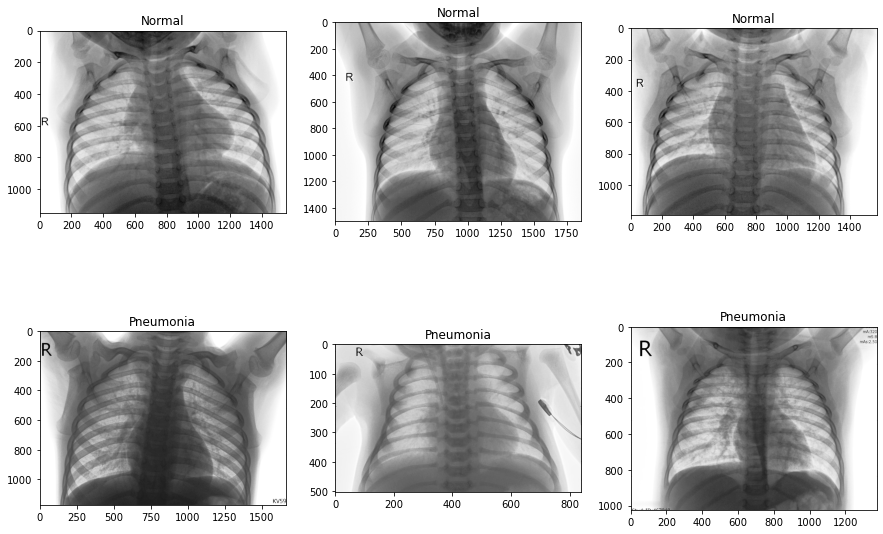

In [25]:
path1 = 'data/train/NORMAL/'
path2 = 'data/train/PNEUMONIA/'
#example = Image.open(path+listdir(path)[0])
imgs = [mpimg.imread(path1+listdir(path1)[0]), 
        mpimg.imread(path1+listdir(path1)[500]),
        mpimg.imread(path1+listdir(path1)[1000]),
        mpimg.imread(path2+listdir(path2)[0]), 
        mpimg.imread(path2+listdir(path2)[500]),
        mpimg.imread(path2+listdir(path2)[1000])]

fig, axes = plt.subplots(2, 3,figsize=(15,10))

for i in range(6):
    nx = i//3
    ny = i%3
    axes[nx,ny].imshow(imgs[i], cmap="Greys")
    if i<3:
        axes[nx, ny].set_title('Normal')
    else:
        axes[nx, ny].set_title('Pneumonia')

## Daten laden und vorverarbeiten
Für die spätere Verwendung mit ResNet18 werden die Bilder auf 224x224 Pixel reskaliert. 

Außerdem wird das Helligkeitsprofil der Bilder auf die gleichen Mittelwerte und Standardabweichungen wie die Inputs des ResNet18 normalisiert.

In [29]:
#Bildgröße
imx = 224
imy = 224

#TRAININGSDATENSATZ LADEN
def load_train(batch_size = 64):
    transform = transforms.Compose(
        #RESIZING
        [transforms.Resize([imx, imy]),
         transforms.RandomAffine(degrees=5*np.pi/180, translate=(0.05,0.05), scale=(0.95,1.05), shear=None, resample=0, fillcolor=0),
         transforms.ToTensor()])
    
    #NORMALISIEREN
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    
    batch_size = batch_size
    data_path = 'data/train/'
    train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transform
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=True
    )
    return train_loader

#TESTDATENSATZ LADEN
def load_test(batch_size = 64):
    transform = transforms.Compose(
        #RESIZING
        [transforms.Resize([imx, imy]),
         transforms.ToTensor()])
    
    #NORMALISIEREN
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    
    batch_size = batch_size

    
    data_path = 'data/test/'
    test_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transform
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=True
    )
    return test_loader

cases = ('normal', 'pneumonia')

## Modell: Transfer Learning auf ResNet18

In [34]:
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Ersetzen des letzten Layers

In [31]:
my_new_layer = nn.Linear(512, 2)
resnet18.fc = my_new_layer

### Training
Trainingsvariablen:

* batch size
* learning rate
* epochs

Für das Training werden hier __Cross Entropy Loss__ und __Adam Optimizer__ genutzt.

Der Adam Optimizer kombiniert die Vorteile von den AdaGrad und RMSProp Algorithmen. AdaGrad 

In [32]:
def train_model(model, epochs = 2, learn_rate = 0.001, batch_size = 64):
    
    train = load_train(batch_size = batch_size)

    criterion = nn.CrossEntropyLoss(weight=weight)
    optimizer = optim.Adam(model.parameters(), lr=learn_rate)
    
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0

        for i, batch in enumerate(train, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = batch
            # Grafikkarte
            #inputs = inputs.to(device)
            #labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            num_feat = imx*imy*3
            outputs = model(inputs)

            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 10))
                running_loss = 0.0

    print('Finished Training')
    
    return model

In [8]:
#batch size < 64 haben uns hier keine verbesserung im loss gegeben
model3 = train_model(resnet18,epochs=1, learn_rate = 0.001, batch_size = 64)

/home/soeren/anaconda3/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607369981906/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


[1,    10] loss: 0.325
[1,    20] loss: 0.096
[1,    30] loss: 0.057
[1,    40] loss: 0.045
[1,    50] loss: 0.059
[1,    60] loss: 0.036
[1,    70] loss: 0.041
[1,    80] loss: 0.056
Finished Training


In [33]:
model2 = train_model(resnet18,epochs=1, learn_rate = 0.001, batch_size = 64)

[1,    10] loss: 0.341
[1,    20] loss: 0.159
[1,    30] loss: 0.086
[1,    40] loss: 0.073
[1,    50] loss: 0.051
[1,    60] loss: 0.061
[1,    70] loss: 0.033
[1,    80] loss: 0.069
Finished Training


## Vorhersagegenauigkeit bestimmen

In [21]:
def test_model(model, batch_size = 64):
    test = load_test(batch_size = batch_size)
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test:
            images, labels = data
            outputs = resnet18(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Die Genauigkeit der Vorhersage beträgt: %d %%' % (
        100 * correct / total))
    return 100*correct/total

In [22]:
test_model(model3)

Die Genauigkeit der Vorhersage beträgt: 87 %


87.01923076923077